# 課題:クラウドファンディング
グアン・ユリ

目的：クラウドファンデイングが成功するか(state)を予測

データセット:Kickstarter Projects

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from copy import deepcopy

In [2]:
#データセットを読み込む
original_data =pd.read_csv('ks-projects-201801.csv')
display(original_data)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),Documentary,Film & Video,USD,2014-10-17,50000.0,2014-09-17 02:35:30,25.0,canceled,1,US,25.0,25.0,50000.00
378657,999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.0,2011-06-22 03:35:14,155.0,failed,5,US,155.0,155.0,1500.00
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.0,2010-07-01 19:40:30,20.0,failed,1,US,20.0,20.0,15000.00
378659,999987933,BioDefense Education Kit,Technology,Technology,USD,2016-02-13,15000.0,2016-01-13 18:13:53,200.0,failed,6,US,200.0,200.0,15000.00


In [3]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


欠損値を確認する

In [4]:
#欠損値を確認する
df_missing = pd.DataFrame(original_data.isnull().sum(), columns=["欠損データ"])

total_count = original_data.shape[0] 
df_missing_rate = df_missing[(df_missing["欠損データ"] > 0)] /total_count*100
df_missing_rate = df_missing_rate.rename(columns={'欠損データ': '全体に占める割合(%)'})
pd.concat([df_missing[(df_missing["欠損データ"] > 0)], df_missing_rate], axis=1)



,欠損データ,全体に占める割合(%)
name,4,0.001056
usd pledged,3797,1.002744


全体に占めている割合は少ないため、欠損値を削除します。

In [5]:
df_adjusted1=original_data.dropna()
df_adjusted1.isnull().sum()

ID                  0
name                0
category            0
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usd pledged         0
usd_pledged_real    0
usd_goal_real       0
dtype: int64

プロジェクトの状況を確認する

In [6]:
df_state = df_adjusted1["state"].value_counts().reset_index().rename(
    columns={"index": "State","state":"Project"})
df_state

,State,Project
0,failed,197611
1,successful,133851
2,canceled,38757
3,live,2798
4,suspended,1843


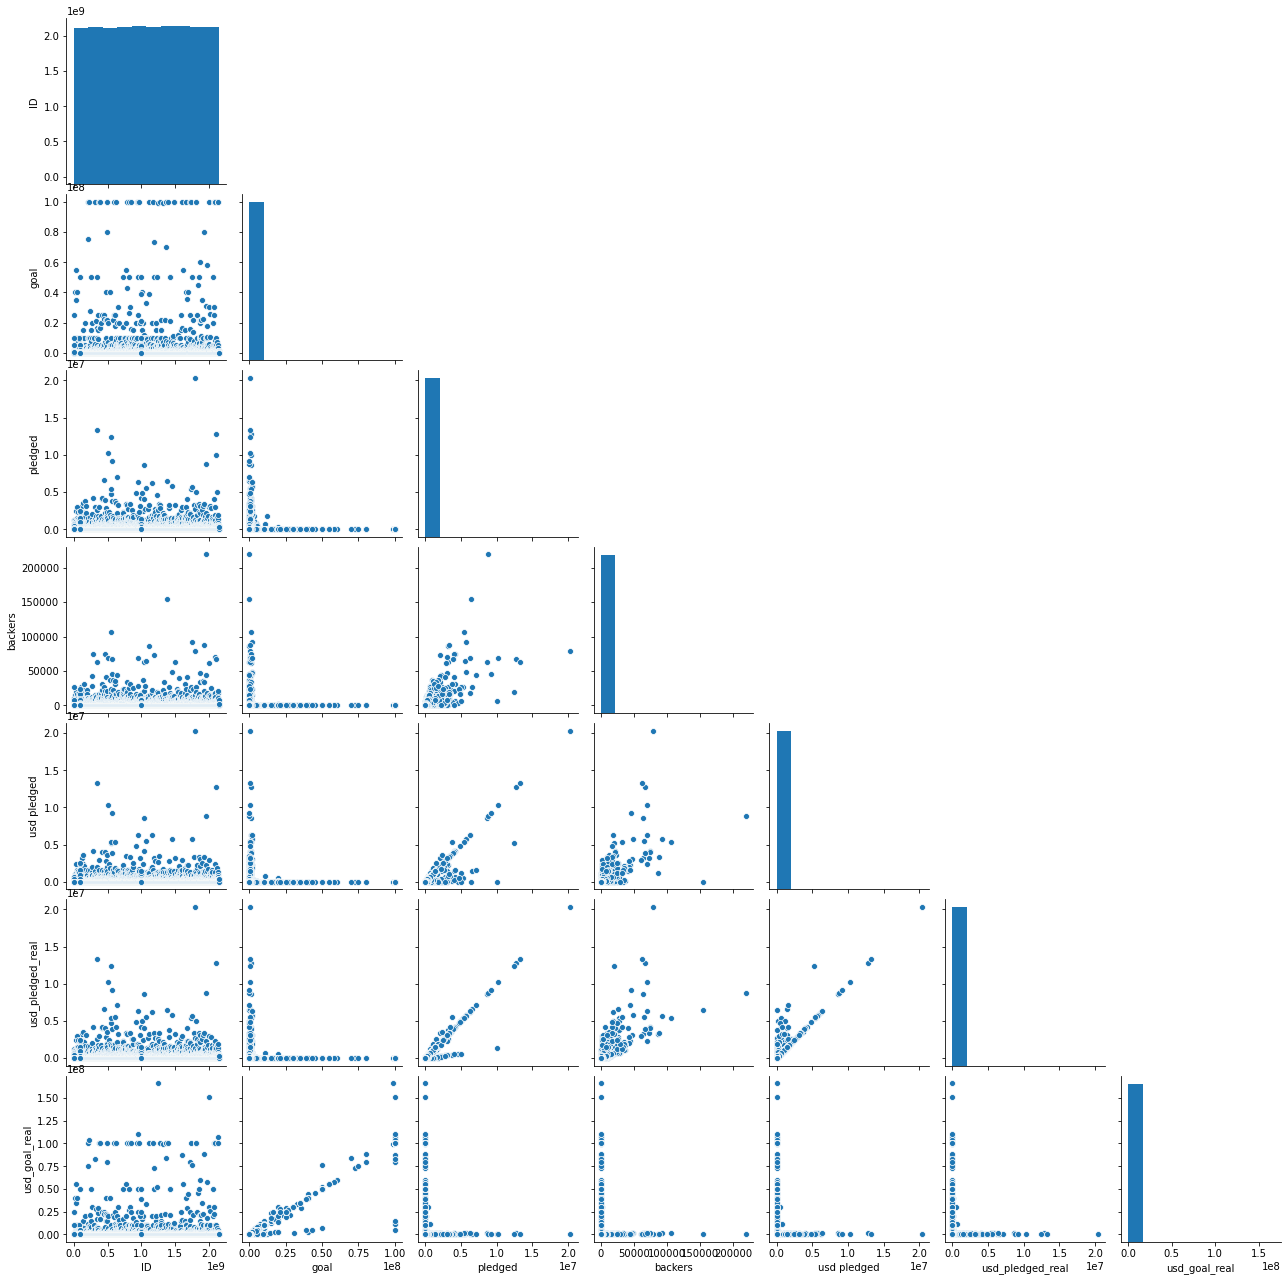

In [7]:
g = sns.pairplot(df_adjusted1)

for i, j in zip(*np.triu_indices_from(g.axes, k=1)):
    g.axes[i, j].set_visible(False)

In [8]:
df_main_category = df_adjusted1["main_category"].value_counts().reset_index().rename(
    columns={"index": "Main Category","main_category":"Project"})
df_main_category

,Main Category,Project
0,Film & Video,62696
1,Music,49530
2,Publishing,39379
3,Games,35225
4,Technology,32562
5,Design,30066
6,Art,28152
7,Food,24599
8,Fashion,22812
9,Theater,10912


In [9]:
df_category = df_adjusted1["category"].value_counts().reset_index().rename(
    columns={"index": "Category","category":"Project"})
df_category

,Category,Project
0,Product Design,22310
1,Documentary,16138
2,Tabletop Games,14178
3,Music,13340
4,Shorts,12357
...,...,...
154,Residencies,69
155,Letterpress,49
156,Chiptune,35
157,Literary Spaces,27


In [10]:
df_country = df_adjusted1["country"].value_counts().reset_index().rename(
    columns={"index": "country","country":"Project"})
df_country

,country,Project
0,US,292624
1,GB,33671
2,CA,14756
3,AU,7839
4,DE,4171
5,FR,2939
6,IT,2878
7,NL,2868
8,ES,2276
9,SE,1757


In [11]:
df_currency = df_adjusted1["currency"].value_counts().reset_index().rename(
    columns={"index": "currency","currency":"Project"})
df_currency

,currency,Project
0,USD,292624
1,GBP,33671
2,EUR,17219
3,CAD,14756
4,AUD,7839
5,SEK,1757
6,MXN,1752
7,NZD,1447
8,DKK,1113
9,CHF,761


In [12]:
df_goal = df_adjusted1["goal"].value_counts().reset_index().rename(
    columns={"index": "goal","goal":"Project"})
df_goal

,goal,Project
0,5000.0,29180
1,10000.0,25980
2,1000.0,16876
3,3000.0,15348
4,2000.0,14903
...,...,...
8307,15995.0,1
8308,23099.0,1
8309,17748.9,1
8310,4785.0,1


In [13]:
df_pledged = df_adjusted1["pledged"].value_counts().reset_index().rename(
    columns={"index": "pledged","pledged":"Project"})
df_pledged

,pledged,Project
0,0.00,51808
1,1.00,9023
2,10.00,4982
3,25.00,3958
4,50.00,3594
...,...,...
61931,10583.88,1
61932,2021.43,1
61933,13023.00,1
61934,6354.07,1


In [14]:
df_backers = df_adjusted1["backers"].value_counts().reset_index().rename(
    columns={"index": "backers","backers":"Project"})
df_backers

,backers,Project
0,0,51811
1,1,34868
2,2,23196
3,3,16063
4,4,12068
...,...,...
3958,2691,1
3959,3712,1
3960,3456,1
3961,74405,1


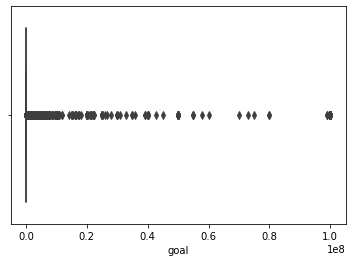

In [15]:
sns.boxplot(df_adjusted1["goal"])
plt.show()

In [16]:
df = deepcopy(df_adjusted1)
df["deadline"] = pd.to_datetime(df["deadline"])
df["launched"] = pd.to_datetime(df["launched"])
df["duration"] = (df["deadline"] - df["launched"]).dt.days
df["launched"] = df["launched"].dt.year

In [17]:
df["category"] = df["category"].astype("category")
df["main_category"] = df["main_category"].astype("category")
df["country"] = df["country"].astype("category")
df["state"] = df["state"].astype("category")
df["state"] = LabelEncoder().fit_transform(df["state"])

In [18]:
df["usd_pledged_diff"] = df["usd_pledged_real"] - df["usd pledged"]

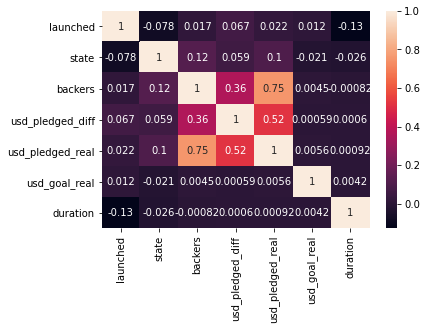

In [19]:
sns.heatmap(df[["launched", "state", "backers", "usd_pledged_diff", "usd_pledged_real", "usd_goal_real", "duration"]].corr(), annot = True)
plt.show()

In [20]:
explanatory_variables = ["category", "main_category", "launched", "backers", "country", "usd_pledged_diff", "usd_pledged_real", "usd_goal_real", "duration"]
target_variable = "state"
x = deepcopy(df[explanatory_variables])
x = pd.get_dummies(x)
y = deepcopy(df[target_variable])

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
display(x_train)
display(y_train)

,launched,backers,usd_pledged_diff,usd_pledged_real,usd_goal_real,duration,category_3D Printing,category_Academic,category_Accessories,category_Action,...,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
227525,2016,41,0.0,532.00,3200.00,59,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
165812,2014,9,0.0,887.00,15000.00,29,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
136986,2017,82,2022.6,2122.39,38446.75,29,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131733,2016,3,-1.8,34.26,356.31,29,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3242,2015,13,0.0,325.00,10000.00,30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363434,2011,5,0.0,120.00,1000.00,32,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
361717,2015,741,0.0,35645.00,14000.00,25,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
153845,2016,1,10.0,10.00,1500.00,29,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
119129,2017,46,6621.0,10938.00,10000.00,35,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


227525    1
165812    1
136986    1
131733    1
3242      1
         ..
363434    1
361717    3
153845    1
119129    3
308812    0
Name: state, Length: 299888, dtype: int32

In [22]:
steps = [
    ('sc', StandardScaler()),
    ('lr', LogisticRegression(multi_class = "multinomial", solver = "sag", random_state = 0, max_iter = 1000, verbose = 2, n_jobs = 6))
]
pipeline = Pipeline(steps = steps)

In [23]:
pipeline.fit(x_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 1261 seconds


C:\Users\YULI\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed: 21.0min finished


Pipeline(steps=[('sc', StandardScaler()),
                ('lr',
                 LogisticRegression(max_iter=1000, multi_class='multinomial',
                                    n_jobs=4, random_state=0, solver='sag',
                                    verbose=2))])

Accuracy : 0.7548818225470842
Precision : 0.33997836065869913
Recall : 0.4869765072000014


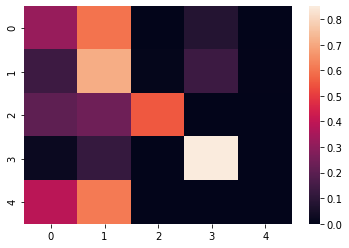

In [24]:
y_pred = pipeline.predict(x_test)
accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test, average = 'macro',zero_division=1)
recall = recall_score(y_pred, y_test, average = 'macro',zero_division=1)
print("Accuracy :", accuracy)
print("Precision :", precision)
print("Recall :", recall)
cm = confusion_matrix(y_pred, y_test, normalize = "true")
sns.heatmap(cm)
plt.show()